In [48]:
# importing necessary libraries
import numpy as np
import pandas as pd

import skimage
from skimage.io import imread, imshow

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [49]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
# reading the upper three rows of the given csv file
df = pd.read_csv('drive/MyDrive/IOT dataset/firmware.csv')
df.head(3)

,filename,class,target,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel986,pixel987,pixel988,pixel989,pixel990,pixel991,pixel992,pixel993,pixel994,pixel995,pixel996,pixel997,pixel998,pixel999,pixel1000,pixel1001,pixel1002,pixel1003,pixel1004,pixel1005,pixel1006,pixel1007,pixel1008,pixel1009,pixel1010,pixel1011,pixel1012,pixel1013,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024,Unnamed: 1027
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,238,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,102,34,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,34,0,0,0,NaN
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,malware,1,85,17,34,34,0,17,17,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,238,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,NaN


In [51]:
# lets see how many values are there per class
df['class'].value_counts()

benignware    38073
malware         711
hackware        103
Name: class, dtype: int64

benignware    38073
malware         711
hackware        103
Name: class, dtype: int64

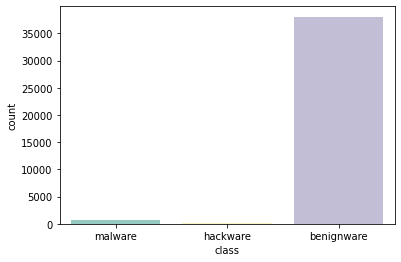

In [52]:
ax = sns.countplot(x='class', data=df, palette="Set3")
df['class'].value_counts()

In [6]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# only taking the file names and their classes- whose images are available
X = []
y = []
positions = []

df_new = pd.DataFrame(columns=['filename', 'class'])

pos = -1
for image_name in df['filename']:
  pos += 1
  try: 
    img = imread('drive/MyDrive/cnn_dataset/images/'+image_name+'.jpg')
    X.append(image_name+'.jpg')
    positions.append(pos)
    
  except FileNotFoundError as not_found:
    continue

for i in positions:
  y.append(df['class'][i])

In [7]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# adding gray image filenames and class in our lists
import os

for filename in os.listdir('drive/MyDrive/cnn_dataset/gray'):
    if filename.endswith("jpg"):  
        X.append(filename)
        y.append('gray')

In [8]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# creating a new dataframe with x and y
df_new = pd.DataFrame(
    {'file_name': X,
     'class_name': y })

In [9]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
df_new['class_name'].value_counts()

benignware    2999
malware        711
gray           669
hackware       103
Name: class_name, dtype: int64

In [10]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# replacing the labels with numerical values
df_new = df_new.replace('benignware', 0)
df_new = df_new.replace('malware', 1)
df_new = df_new.replace('hackware', 2)
df_new = df_new.replace('gray', 3)
df_new

,file_name,class_name
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
3,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
4,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
...,...,...
4477,lightslategrey.jpg,3
4478,mediumorchid.jpg,3
4479,burlywood3.jpg,3
4480,paleturquoise1.jpg,3


In [11]:
'''SKIP THIS CELL IF THE CSV FILE HAS ALREADY BEEN CREATED'''
# creating the new csv file
df_new.to_csv('modified_dataset.csv')
!cp modified_dataset.csv "drive/My Drive/cnn_dataset"

In [53]:
# placing the manual_seed value as my student id
torch.manual_seed(170204059)
np.random.seed(170204059)

In [54]:
df_new = pd.read_csv('drive/My Drive/cnn_dataset/modified_dataset.csv')
df_new.head(3)

,Unnamed: 0,file_name,class_name
0,0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
1,1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
2,2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1


In [55]:
# removing 'Unnamed: 0' column from our dataframe
df_new = df_new.iloc[:, 1:]
df_new.head(3)

,file_name,class_name
0,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
1,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1
2,x86__64__lsb__unix-system-v__clang-3.8.0__O0__...,1


In [56]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4482 entries, 0 to 4481
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   4482 non-null   object
 1   class_name  4482 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.2+ KB


In [57]:
# creating the Dataset class
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [58]:
# setting up mean and std for 1 channel images
mean = [0.5,]
std =  [0.5,]

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#Instantiate the Dataset Class
dataset  = Dataset(df_new, 'drive/MyDrive/cnn_dataset/images_all.zip (Unzipped Files)/images_all', transform)

print("Total Samples: ", len(dataset))

Total Samples:  4482


In [59]:
# bathc size and test size are set per assignemnt instruction
batch_size = 20
test_size = 0.2

# shuffling the indices of the dataset
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# setting the split position of the dataset
split = int(np.floor(test_size * len(dataset)))
train_index, test_index = indices[split:], indices[:split]

# defining the sampler
train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

# preparing the loaders; the dataset is already shuffled 
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size = batch_size, sampler=train_sampler, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size = batch_size, sampler=test_sampler, shuffle=False)

print(f"Total train dataloader: {len(train_loader)}")
print(f"Total test dataloader: {len(test_loader)}")

Total train dataloader: 180
Total test dataloader: 45


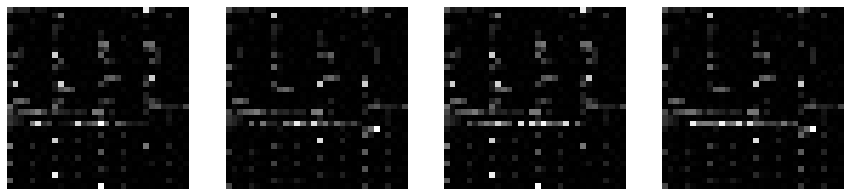

In [60]:
# the first four images of the dataset
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(15,15))
for i in range(0,4):
    ax[i].imshow(dataset[i][0].numpy().reshape(32, 32), cmap='gray')
    ax[i].axis('off')

In [61]:
# defining Hyperparameters
# batch_size has been already defined

num_iters = 2000
input_dim = 32*32 
output_dim = 4
learning_rate = 0.001

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [62]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 100) 
        self.layer_2 = nn.Linear(100, 100) 
        self.layer_3 = nn.Linear(100, 100)   
        self.layer_4 = nn.Linear(100, 100)  
        self.layer_5 = nn.Linear(100, 100) 
        self.layer_6 = nn.Linear(100, 4)   
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        

    def forward(self, x):

        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_3(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_4(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.layer_5(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        logits  = self.layer_6(x)
        return logits

In [63]:
model = NeuralNetwork(input_dim)
model.to(device)

NeuralNetwork(
  (layer_1): Linear(in_features=1024, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=100, bias=True)
  (layer_4): Linear(in_features=100, out_features=100, bias=True)
  (layer_5): Linear(in_features=100, out_features=100, bias=True)
  (layer_6): Linear(in_features=100, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [64]:
# optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
import math

# calculating number of epochs
num_epochs = num_iters / (len(train_index) / batch_size)
num_epochs = int(math.ceil(num_epochs))
loss_list = []

n_total_steps = len(train_loader)

iter = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):

    images = images.view(-1, 32*32).to(device)
    labels = labels.to(device)

    # clearing gradients with respect to parameters
    optimizer.zero_grad()

    # forward pass 
    outputs = model(images) 

    # calculating loss
    loss = criterion(outputs, labels)

    # getting gradients with respect to parameters
    loss.backward()

    # updating the parameters
    optimizer.step()      

    if (i+1) % 10 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      loss_list.append(loss.item())
print('Finished Training')

Epoch [1/12], Step [10/180], Loss: 1.2717
Epoch [1/12], Step [20/180], Loss: 0.8536
Epoch [1/12], Step [30/180], Loss: 0.9918
Epoch [1/12], Step [40/180], Loss: 1.1091
Epoch [1/12], Step [50/180], Loss: 0.8593
Epoch [1/12], Step [60/180], Loss: 1.0348
Epoch [1/12], Step [70/180], Loss: 0.9466
Epoch [1/12], Step [80/180], Loss: 0.6579
Epoch [1/12], Step [90/180], Loss: 0.7672
Epoch [1/12], Step [100/180], Loss: 0.6065
Epoch [1/12], Step [110/180], Loss: 0.4240
Epoch [1/12], Step [120/180], Loss: 0.8226
Epoch [1/12], Step [130/180], Loss: 0.9020
Epoch [1/12], Step [140/180], Loss: 0.8183
Epoch [1/12], Step [150/180], Loss: 0.9571
Epoch [1/12], Step [160/180], Loss: 0.8474
Epoch [1/12], Step [170/180], Loss: 0.6172
Epoch [1/12], Step [180/180], Loss: 0.3033
Epoch [2/12], Step [10/180], Loss: 0.7339
Epoch [2/12], Step [20/180], Loss: 0.8825
Epoch [2/12], Step [30/180], Loss: 1.1539
Epoch [2/12], Step [40/180], Loss: 0.9207
Epoch [2/12], Step [50/180], Loss: 0.9821
Epoch [2/12], Step [60/18

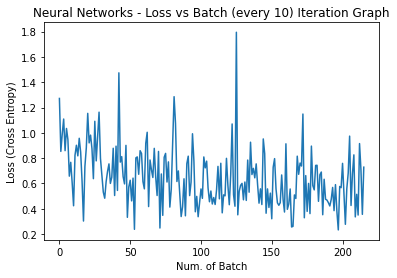

In [66]:
# plotting the loss per batch graph

plt.plot(loss_list)
 

plt.xlabel('Num. of Batch')
plt.ylabel('Loss (Cross Entropy)')
 
plt.title('Neural Networks - Loss vs Batch (every 10) Iteration Graph')
 
plt.show()

In [67]:
with torch.no_grad():
  n_correct = 0
  n_incorrect = 0
  n_samples = 0
  n_class_correct = [0 for i in range(4)]
  n_class_incorrect = [0 for i in range(4)]
  n_class_predicted = [0 for i in range(4)]
  n_class_samples = [0 for i in range(4)]


  for images, labels in test_loader:
    images = images.view(-1, 32*32).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    n_incorrect += (predicted != labels).sum().item()
    
    for i in range(len(labels)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      else:
        n_class_incorrect[label] += 1
      n_class_predicted[pred] += 1  
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 80.58035714285714 %


In [71]:
n_class_samples

[595, 144, 23, 134]

In [72]:
n_class_correct 

[592, 0, 0, 130]

In [73]:
n_class_predicted

[763, 0, 0, 133]

In [68]:
classes = ['benignware', 'malware', 'hackware', 'gray']
total_pre = []
total_rec = []

for i in range(4):
  acc = n_class_correct[i] / n_class_samples[i]
  try:
    pre = n_class_correct[i] / (n_class_correct[i] + (n_class_predicted[i]-n_class_correct[i]))
  except ZeroDivisionError:
    rec = 0
  total_pre.append(pre)
  try:
    rec = n_class_correct[i] / n_class_predicted[i] 
  except ZeroDivisionError:
    rec = 0
  total_rec.append(rec) 
  '''
  try:
    f1 = ((2*total_pre.sum()*total_rec.sum())/(total_pre.sum()+total_rec.sum()))/4
  except ZeroDivisionError:
    f1 = 'undefined'
  '''
  f1 = (2*sum(total_pre)*sum(total_rec))/(sum(total_pre)+sum(total_rec))/4
print(f'F-1 Score: {f1}')

F-1 Score: 0.5727988528848855


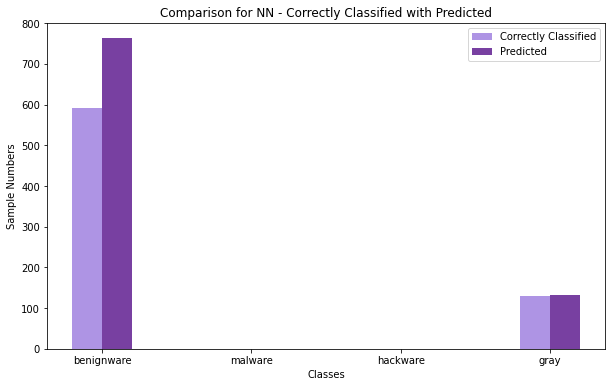

In [69]:
index = np.arange(0, 4)
width = 0.2
plt.figure(figsize = (10, 6))
plt.title('Comparison for NN - Correctly Classified with Predicted')

plt.bar(index , n_class_correct, width, color='mediumpurple', label='Correctly Classified', alpha=0.75)
plt.bar(index + width, n_class_predicted, width, color='indigo', label='Predicted', alpha=0.75)
  
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(index+width/2, classes)
plt.legend()
plt.show()

In [74]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) #in_channels, out_channels, filter (3X3)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 30, 3)
        self.fc1 = nn.Linear(30 * 2 * 2, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 4)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()


    def forward(self, x):       #input, channel, width, height 
                                # -> n, 1, 32, 32               
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 6, 15, 15
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 16, 6, 6
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x) 
                                # -> n, 30, 2, 2 
        x = x.view(-1, 30*2*2)              
                                # -> n, 120 
        x = self.fc1(x)
        x = self.relu(x)                         
                                # -> n, 60 
        x = self.fc2(x)
        x = self.relu(x)                         
                                # -> n, 30
        x = self.fc3(x)         
        x = self.relu(x)
                                # -> n, 15
        x = self.fc4(x)                         
                                # -> n, 4
                                              
        return x

In [75]:
model = ConvNet2()
model.to(device)

ConvNet2(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=15, bias=True)
  (fc4): Linear(in_features=15, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [77]:
import math

# calculating number of epochs
num_epochs = num_iters / (len(train_index) / batch_size)
num_epochs = int(math.ceil(num_epochs))
loss_list = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_list.append(loss.item())
print('Finished Training')

Epoch [1/12], Step [10/180], Loss: 1.1809
Epoch [1/12], Step [20/180], Loss: 0.9553
Epoch [1/12], Step [30/180], Loss: 0.7265
Epoch [1/12], Step [40/180], Loss: 0.8171
Epoch [1/12], Step [50/180], Loss: 1.2395
Epoch [1/12], Step [60/180], Loss: 0.7321
Epoch [1/12], Step [70/180], Loss: 0.5566
Epoch [1/12], Step [80/180], Loss: 0.5382
Epoch [1/12], Step [90/180], Loss: 0.4515
Epoch [1/12], Step [100/180], Loss: 0.4256
Epoch [1/12], Step [110/180], Loss: 0.4397
Epoch [1/12], Step [120/180], Loss: 0.3121
Epoch [1/12], Step [130/180], Loss: 0.3447
Epoch [1/12], Step [140/180], Loss: 0.4195
Epoch [1/12], Step [150/180], Loss: 0.9296
Epoch [1/12], Step [160/180], Loss: 0.5144
Epoch [1/12], Step [170/180], Loss: 0.3481
Epoch [1/12], Step [180/180], Loss: 0.6642
Epoch [2/12], Step [10/180], Loss: 0.8888
Epoch [2/12], Step [20/180], Loss: 0.8529
Epoch [2/12], Step [30/180], Loss: 0.3251
Epoch [2/12], Step [40/180], Loss: 0.5588
Epoch [2/12], Step [50/180], Loss: 0.7246
Epoch [2/12], Step [60/18

In [78]:
with torch.no_grad():
  n_correct = 0
  n_incorrect = 0
  n_samples = 0
  n_class_correct = [0 for i in range(4)]
  n_class_incorrect = [0 for i in range(4)]
  n_class_predicted = [0 for i in range(4)]
  n_class_samples = [0 for i in range(4)]


  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    n_incorrect += (predicted != labels).sum().item()
    
    for i in range(len(labels)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      else:
        n_class_incorrect[label] += 1
      n_class_predicted[pred] += 1  
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 83.81696428571429 %


In [79]:
n_class_samples

[595, 144, 23, 134]

In [80]:
n_class_correct

[552, 65, 0, 134]

In [81]:
n_class_predicted

[642, 120, 0, 134]

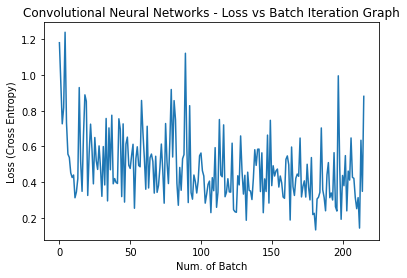

In [82]:
# plotting the loss per batch graph

plt.plot(loss_list)

plt.xlabel('Num. of Batch')
plt.ylabel('Loss (Cross Entropy)')
 
plt.title('Convolutional Neural Networks - Loss vs Batch Iteration Graph')
 
plt.show()

In [83]:
classes = ['benignware', 'malware', 'hackware', 'gray']
total_pre = []
total_rec = []

for i in range(4):
  acc = n_class_correct[i] / n_class_samples[i]
  try:
    pre = n_class_correct[i] / (n_class_correct[i] + (n_class_predicted[i]-n_class_correct[i]))
  except ZeroDivisionError:
    rec = 0
  total_pre.append(pre)
  try:
    rec = n_class_correct[i] / n_class_predicted[i] 
  except ZeroDivisionError:
    rec = 0
  total_rec.append(rec) 
  '''
  try:
    f1 = ((2*total_pre.sum()*total_rec.sum())/(total_pre.sum()+total_rec.sum()))/4
  except ZeroDivisionError:
    f1 = 'undefined'
  '''
  f1 = (2*sum(total_pre)*sum(total_rec))/(sum(total_pre)+sum(total_rec))/4
print(f'F-1 Score: {f1}')

F-1 Score: 0.6612161732745462


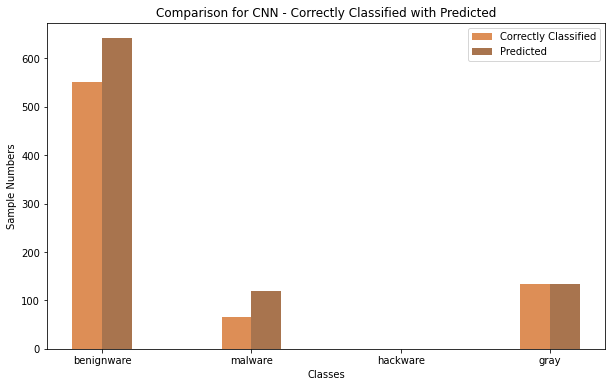

In [84]:
index = np.arange(0, 4)
width = 0.2
plt.figure(figsize = (10, 6))
plt.title('Comparison for CNN - Correctly Classified with Predicted')

plt.bar(index , n_class_correct, width, color='chocolate', label='Correctly Classified', alpha=0.75)
plt.bar(index + width, n_class_predicted, width, color='saddlebrown', label='Predicted', alpha=0.75)
  
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(index+width/2, classes)
plt.legend()
plt.show()

In [85]:
# following LeNet-5
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #in_channels, out_channels, filter (5X5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()


    def forward(self, x):
                                # -> n, 1, 32, 32               
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 6, 14, 14
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)                       
                                # -> n, 16, 5, 5
        x = x.view(-1, 16*5*5)  # -> n, 400             
        
        x = self.fc1(x)
        x = self.relu(x)                         
                                # -> n, 120 
        x = self.fc2(x)
        x = self.relu(x)                         
                                # -> n, 84
        x = self.fc3(x)         
                                # -> n, 4              
        return x


In [98]:
model = ConvNet1()
model.to(device)

ConvNet1(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [100]:
import math

# calculating number of epochs
num_epochs = num_iters / (len(train_index) / batch_size)
num_epochs = int(math.ceil(num_epochs))
loss_list = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_list.append(loss.item())
print('Finished Training')

Epoch [1/12], Step [10/180], Loss: 0.9957
Epoch [1/12], Step [20/180], Loss: 0.3870
Epoch [1/12], Step [30/180], Loss: 0.7381
Epoch [1/12], Step [40/180], Loss: 0.5652
Epoch [1/12], Step [50/180], Loss: 0.5866
Epoch [1/12], Step [60/180], Loss: 0.6850
Epoch [1/12], Step [70/180], Loss: 0.7815
Epoch [1/12], Step [80/180], Loss: 0.9118
Epoch [1/12], Step [90/180], Loss: 0.8356
Epoch [1/12], Step [100/180], Loss: 0.2595
Epoch [1/12], Step [110/180], Loss: 0.7481
Epoch [1/12], Step [120/180], Loss: 0.5199
Epoch [1/12], Step [130/180], Loss: 0.8687
Epoch [1/12], Step [140/180], Loss: 0.3502
Epoch [1/12], Step [150/180], Loss: 0.5862
Epoch [1/12], Step [160/180], Loss: 0.6570
Epoch [1/12], Step [170/180], Loss: 0.9525
Epoch [1/12], Step [180/180], Loss: 0.9113
Epoch [2/12], Step [10/180], Loss: 0.2097
Epoch [2/12], Step [20/180], Loss: 0.5293
Epoch [2/12], Step [30/180], Loss: 0.7583
Epoch [2/12], Step [40/180], Loss: 0.3833
Epoch [2/12], Step [50/180], Loss: 0.4138
Epoch [2/12], Step [60/18

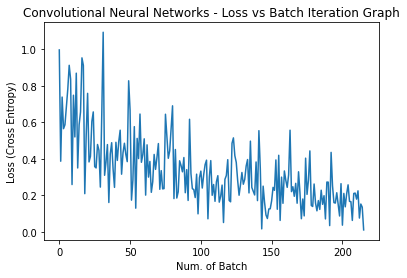

In [101]:
# plotting the loss per batch graph

plt.plot(loss_list)
 

plt.xlabel('Num. of Batch')
plt.ylabel('Loss (Cross Entropy)')
 
plt.title('Convolutional Neural Networks - Loss vs Batch Iteration Graph')
 
plt.show()

In [103]:
with torch.no_grad():
  n_correct = 0
  n_incorrect = 0
  n_samples = 0
  n_class_correct = [0 for i in range(4)]
  n_class_incorrect = [0 for i in range(4)]
  n_class_predicted = [0 for i in range(4)]
  n_class_samples = [0 for i in range(4)]


  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
    n_incorrect += (predicted != labels).sum().item()
    
    for i in range(len(labels)):
      label = labels[i]
      pred = predicted[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_predicted[pred] += 1  
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 92.96875 %


In [106]:
n_class_samples

[595, 144, 23, 134]

In [107]:
n_class_correct

[577, 109, 13, 134]

In [108]:
n_class_predicted

[622, 126, 14, 134]

In [104]:
classes = ['benignware', 'malware', 'hackware', 'gray']
total_pre = []
total_rec = []

for i in range(4):
  acc = n_class_correct[i] / n_class_samples[i]
  try:
    pre = n_class_correct[i] / (n_class_correct[i] + (n_class_predicted[i]-n_class_correct[i]))
  except ZeroDivisionError:
    rec = 0
  total_pre.append(pre)
  try:
    rec = n_class_correct[i] / n_class_predicted[i] 
  except ZeroDivisionError:
    rec = 0
  total_rec.append(rec) 
  '''
  try:
    f1 = ((2*total_pre.sum()*total_rec.sum())/(total_pre.sum()+total_rec.sum()))/4
  except ZeroDivisionError:
    f1 = 'undefined'
  '''
  f1 = (2*sum(total_pre)*sum(total_rec))/(sum(total_pre)+sum(total_rec))/4
print(f'F-1 Score: {f1}')

F-1 Score: 0.9303258816924411


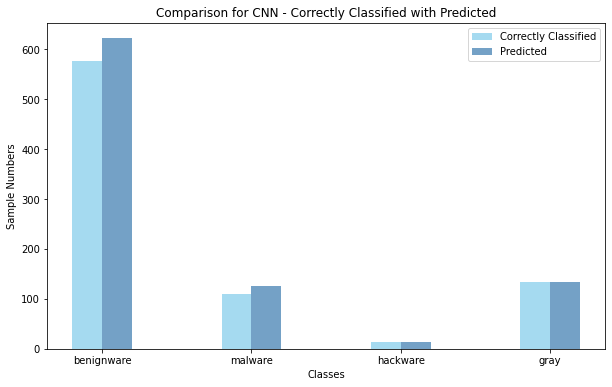

In [105]:
index = np.arange(0, 4)
width = 0.2
plt.figure(figsize = (10, 6))
plt.title('Comparison for CNN - Correctly Classified with Predicted')

plt.bar(index , n_class_correct, width, color='skyblue', label='Correctly Classified', alpha=0.75)
plt.bar(index + width, n_class_predicted, width, color='steelblue', label='Predicted', alpha=0.75)
  
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(index+width/2, classes)
plt.legend()
plt.show()